# Distribution and framewise stats
This notebook explores the distribution of the data and how the data differs from frame to frame. 

This notebook loads the baseline files, creates histograms of the intensities, calculates and plots descriptive stats and the frame to frame differences

 
Author: Brynn Harris-Shanks

## Set-up

In [11]:
from pathlib import Path
import os
import sys
import yaml

# Locate repo root
repo_root = next(
    p for p in (Path.cwd(), *Path.cwd().parents)
    if (p / "config" / "config.yml").exists()
)

# Add code directory to import path
code_dir = repo_root / "code"
if str(code_dir) not in sys.path:
    sys.path.insert(0, str(code_dir))

# Load config
config_path = repo_root / "config" / "config.yml"
config = yaml.safe_load(config_path.read_text(encoding="utf-8"))

In [12]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from utils import autocorrelation as acf
from utils import helper_functions as hf
from IPython import get_ipython

In [13]:
# Inline backend
USE_WIDGET = False
ipy = get_ipython()
backend_mode = "inline"
if ipy is not None:
    try:
        ipy.run_line_magic("matplotlib", "inline")
    except Exception:
        pass
print(f"Matplotlib backend: {matplotlib.get_backend()} | mode={backend_mode}")

# Core paths
deriv_root = repo_root / config["paths"]["preprocessing"]
subjects = config["subjects"]["all"]
sample_subject = config["subjects"]["default"]
data_mode = "zscore"
sample_session_idx = 2
sample_frame_idx = 0

Matplotlib backend: inline | mode=inline


In [14]:
# Specific to this notebook
eda_cfg = config["eda"]
eda_root_name = eda_cfg["root_name"]
acf_qc_filename = eda_cfg["acf_qc_filename"]
analysis_modes = eda_cfg["analysis_modes"]

fdiff_robust_pctl = tuple(float(x) for x in eda_cfg["frame_diff_robust_percentiles"])
spatial_eps = float(eda_cfg["spatial_eps"])
spatial_min_valid_samples = int(eda_cfg["spatial_min_valid_samples"])
DIST_RNG_SEED = 42
DIST_RAW_RANGE_PERCENTILES = (1.0, 99.0)
DIST_HIST_FIGSIZE = (15.0, 4.2)
DIST_SAVE_DPI = 180
TIME_STATS_FIGSIZE = (12.0, 10.0)
TIME_STATS_SAVE_DPI = 180
FRAME_DIFF_METHOD = "consecutive"
FDIFF_ROOT_SUBDIR = "frame_diff"
FRAME_DIFF_FIGSIZE = (11.0, 9.0)
FRAME_DIFF_SAVE_DPI = 180
GLOBAL_SIGNAL_MODES = [m for m in ["raw", "mean_divide"] if m in analysis_modes]
if len(GLOBAL_SIGNAL_MODES) == 0 and len(analysis_modes) > 0:
    GLOBAL_SIGNAL_MODES = [analysis_modes[0]]
    
# Distribution config (shared)
dist_cfg = eda_cfg["distribution"]

DIST_N_BINS = int(dist_cfg["n_bins"])
DIST_MAX_POINTS = int(dist_cfg["max_points"])
DIST_MODE_ORDER = list(analysis_modes)
DIST_MODE_RANGES = {k: tuple(v) for k, v in dist_cfg["mode_ranges"].items()}

---
### Load Baseline Data

Load baseline sessions for model training.

In [15]:
baseline_output_dir = deriv_root / sample_subject / "baseline_only"
baseline_sessions = hf.load_all_baseline(str(baseline_output_dir))

for subject in subjects:
    data_output_dir = deriv_root / subject  # subject-specific output folder
    data_output_dir.mkdir(parents=True, exist_ok=True)
    if data_mode == "raw":
        baseline_output_dir = os.path.join(data_output_dir, "baseline_only")
    else:
        baseline_output_dir = os.path.join(
            data_output_dir, f"baseline_only_normalized/{data_mode}"
        )
    # Load all baseline sessions
    baseline_sessions = hf.load_saved_baseline_sessions(baseline_output_dir)

    # Print summary
    if len(baseline_sessions) > 0:
        print(f"\nBaseline Data Summary:{subject} ({data_mode})")
        print(f"  Total sessions: {len(baseline_sessions)}")
        total_frames = sum(s["frames"].shape[0] for s in baseline_sessions)
        print(f"  Total baseline frames: {total_frames:,}")

        spatial_shapes = [s["frames"].shape[1:] for s in baseline_sessions]
        unique_shapes = set(spatial_shapes)
        print(f"  Spatial dimensions: {unique_shapes}")

        # Show frame count distribution
        frame_counts = [s["frames"].shape[0] for s in baseline_sessions]
        print(
            f"  Frames per session: min={min(frame_counts)}, max={max(frame_counts)}, "
            f"mean={np.mean(frame_counts):.0f}, std={np.std(frame_counts):.0f}"
        )

        # first session
        if len(baseline_sessions) > 0:
            first_session = baseline_sessions[0]
            print(f"\n  First session ({first_session['session_id']}):")
            print(f"    Frames: {first_session['frames'].shape[0]}")
            print(f"    Shape: {first_session['frames'].shape}")
            print(f"    Dtype: {first_session['frames'].dtype}")
            print(
                f"Value range: [{first_session['frames'].min():.2f}, {first_session['frames'].max():.2f}]"
            )

Loaded 34 baseline sessions

Baseline Data Summary:secundo (zscore)
  Total sessions: 34
  Total baseline frames: 14,043
  Spatial dimensions: {(107, 128), (132, 128), (101, 128), (112, 128), (96, 128), (91, 128), (122, 128)}
  Frames per session: min=1, max=906, mean=413, std=202

  First session (Se01072020):
    Frames: 526
    Shape: (526, 101, 128)
    Dtype: float32
Value range: [-4.49, 10.65]

Baseline Data Summary:gus (zscore)
  Total sessions: 13
  Total baseline frames: 5,838
  Spatial dimensions: {(132, 128), (101, 128), (112, 128), (96, 128), (81, 128), (122, 128)}
  Frames per session: min=258, max=549, mean=449, std=123

  First session (Gu03092020):
    Frames: 539
    Shape: (539, 112, 128)
    Dtype: float32
Value range: [-4.97, 11.45]


---
## Exploratory data analysis

---

### 2. Distributions
will display just a sample acquisition, but will save plots for each acquisition
#### Histograms of intensities
per acquisiton 

Loaded 34 baseline sessions

[secundo] per-acquisition histograms | sessions=34


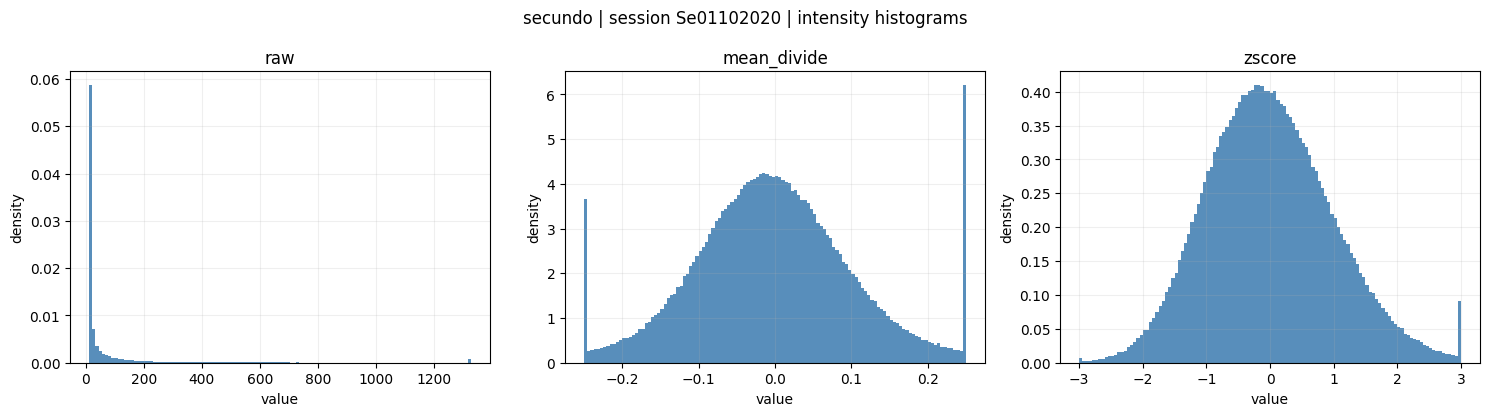

Saved per-acquisition histograms to: c:\Users\ESPCI\Documents\GitHub\fUSPredict\derivatives\preprocessing\secundo\eda\distribution\hist_per_acquisition
Loaded 13 baseline sessions

[gus] per-acquisition histograms | sessions=13
Saved per-acquisition histograms to: c:\Users\ESPCI\Documents\GitHub\fUSPredict\derivatives\preprocessing\gus\eda\distribution\hist_per_acquisition


In [16]:
def _eda_subject_root(subject):
    root = deriv_root / subject / eda_root_name / "distribution"
    root.mkdir(parents=True, exist_ok=True)
    return root


def _mode_transform(frames, mode, subject, session_id):
    arr = hf.load_saved_session_frames(deriv_root, subject, session_id, mode)
    if arr.shape != frames.shape:
        raise ValueError(
            f"Shape mismatch for {subject}/{session_id}/{mode}: raw={frames.shape}, saved={arr.shape}"
        )
    return arr


def _flatten_for_hist(arr, max_points=DIST_MAX_POINTS, seed=DIST_RNG_SEED):
    v = arr.reshape(-1)
    n = v.size
    if n <= max_points:
        return v
    rng = np.random.default_rng(seed)
    idx = rng.choice(n, size=max_points, replace=False)
    return v[idx]


def _subject_raw_range(
    baseline_sessions,
    q_low=DIST_RAW_RANGE_PERCENTILES[0],
    q_high=DIST_RAW_RANGE_PERCENTILES[1],
):
    lows, highs = [], []
    for sess in baseline_sessions:
        f = sess["frames"].astype(np.float32, copy=False)
        lows.append(float(np.percentile(f, q_low)))
        highs.append(float(np.percentile(f, q_high)))
    lo = float(np.median(lows)) if len(lows) else 0.0
    hi = float(np.median(highs)) if len(highs) else 1.0
    if hi <= lo:
        hi = lo + 1e-6
    return lo, hi


for subject in subjects:
    subject_root = _eda_subject_root(subject)
    out_dir = subject_root / "hist_per_acquisition"
    out_dir.mkdir(parents=True, exist_ok=True)

    baseline_output_dir = deriv_root / subject / "baseline_only"
    baseline_sessions = hf.load_all_baseline(str(baseline_output_dir))

    if len(baseline_sessions) == 0:
        print(
            f"No baseline sessions for {subject}; skipping per-acquisition histograms"
        )
        continue

    # subject-specific robust range for raw
    raw_lo, raw_hi = _subject_raw_range(baseline_sessions)
    mode_ranges = dict(DIST_MODE_RANGES)
    mode_ranges["raw"] = (raw_lo, raw_hi)

    print(
        f"\n[{subject}] per-acquisition histograms | sessions={len(baseline_sessions)}"
    )

    for s_idx, sess in enumerate(baseline_sessions):
        session_id = sess["session_id"]
        raw = sess["frames"].astype(np.float32, copy=False)

        fig, axes = plt.subplots(1, 3, figsize=DIST_HIST_FIGSIZE)

        for ax, mode in zip(axes, DIST_MODE_ORDER, strict=False):
            arr = _mode_transform(raw, mode, subject, session_id)
            vals = _flatten_for_hist(
                arr,
                max_points=DIST_MAX_POINTS,
                seed=DIST_RNG_SEED + s_idx,
            )

            lo, hi = mode_ranges[mode]
            vals_plot = np.clip(vals, lo, hi)

            ax.hist(
                vals_plot,
                bins=DIST_N_BINS,
                range=(lo, hi),
                density=True,
                alpha=0.9,
                color="steelblue",
            )
            
            ax.set_title(mode)
            ax.set_xlabel("value")
            ax.set_ylabel("density")
            ax.grid(alpha=0.2)

        fig.suptitle(f"{subject} | session {session_id} | intensity histograms")
        fig.tight_layout()

        out_path = out_dir / f"{subject}_{session_id}_hist_triplet.png"
        fig.savefig(out_path, dpi=DIST_SAVE_DPI)

        if subject == sample_subject and s_idx == sample_session_idx:
            plt.show()
        else:
            plt.close(fig)

    print(f"Saved per-acquisition histograms to: {out_dir}")

#### mean/median/max intensity values over time
per acquisition

In [17]:
def compute_framewise_stats(frames_3d):
    arr = np.asarray(frames_3d, dtype=np.float32)
    flat = arr.reshape(arr.shape[0], -1)

    p25 = np.nanpercentile(flat, 25.0, axis=1)
    p75 = np.nanpercentile(flat, 75.0, axis=1)

    dvars = np.full(flat.shape[0], np.nan, dtype=np.float32)
    if flat.shape[0] > 1:
        dvars[1:] = np.nanmean(np.abs(flat[1:] - flat[:-1]), axis=1)

    return {
        "mean": np.nanmean(flat, axis=1),
        "median": np.nanmedian(flat, axis=1),
        # "p99": np.nanpercentile(flat, 99.0, axis=1),
        # "p99_9": np.nanpercentile(flat, 99.9, axis=1),
        "std": np.nanstd(flat, axis=1),
        "iqr": p75 - p25,
        "dvars": dvars,
    }


TARGET_MODES = list(analysis_modes)

for subject in subjects:
    subject_root = _eda_subject_root(subject)
    out_dir = subject_root / "time_stats_per_acquisition"
    out_dir.mkdir(parents=True, exist_ok=True)

    baseline_output_dir = deriv_root / subject / "baseline_only"
    baseline_sessions = hf.load_all_baseline(str(baseline_output_dir))

    if len(baseline_sessions) == 0:
        print(
            f"No baseline sessions for {subject}; skipping per-acquisition time stats"
        )
        continue
    print(
        f"\n[{subject}] per-acquisition robust framewise stats | sessions={len(baseline_sessions)}"
    )

    for s_idx, sess in enumerate(baseline_sessions):
        session_id = acf.canonical_session_id(sess["session_id"], TARGET_MODES)

        stats = {}
        frame_count = None
        missing_modes = []

        for mode in TARGET_MODES:
            try:
                arr = hf.load_saved_session_frames(
                    deriv_root,
                    subject,
                    session_id,
                    mode,
                )
                arr = acf.squeeze_frames(arr).astype(np.float32, copy=False)
            except Exception as e:
                print(
                    f"{subject} | session {session_id} | mode {mode}: failed to load ({e})"
                )
                missing_modes.append(mode)
                continue

            if frame_count is None:
                frame_count = arr.shape[0]
            elif arr.shape[0] != frame_count:
                print(
                    f"{subject} | session {session_id}: frame count mismatch "
                    f"({frame_count} vs {arr.shape[0]}) across modes; skipping session"
                )
                missing_modes = TARGET_MODES.copy()
                break

            stats[mode] = compute_framewise_stats(arr)

        if missing_modes:
            print(
                f"{subject} | session {session_id}: missing/invalid modes {missing_modes}; skipping"
            )
            continue

        t = np.arange(frame_count)
        colors = {"raw": "tab:green", "mean_divide": "tab:orange", "zscore": "tab:blue"}
        linestyles = {
            "mean": "-",
            "median": "--",
            # "p99": "-",
            # "p99_9": "--",
            "std": "-",
            "iqr": "--",
            "dvars": "-",
        }

        panel_defs = [
            ("mean + median", ["mean", "median"]),
            # ("p99 + p99.9", ["p99", "p99_9"]),
            ("std + iqr", ["std", "iqr"]),
            ("dvars (frame 0 = NaN)", ["dvars"]),
        ]

        fig, axes = plt.subplots(3, 1, figsize=TIME_STATS_FIGSIZE, sharex=True)
        for ax, (title, metrics) in zip(axes, panel_defs, strict=False):
            for mode in TARGET_MODES:
                for metric in metrics:
                    ax.plot(
                        t,
                        stats[mode][metric],
                        color=colors.get(mode, None),
                        linestyle=linestyles[metric],
                        linewidth=1.4,
                        label=f"{mode} {metric}",
                    )
            ax.set_title(title)
            ax.set_ylabel("value")
            ax.grid(alpha=0.2)
            ax.legend(fontsize=8, ncol=2, loc="best")

        axes[-1].set_xlabel("Frame index")
        fig.suptitle(f"{subject} | session {session_id} | framewise stats")
        fig.tight_layout(rect=[0, 0, 1, 0.97])

        out_fig = out_dir / f"{subject}_{session_id}_time_stats_triplet.png"
        fig.savefig(out_fig, dpi=TIME_STATS_SAVE_DPI)

        rows = []
        for mode in TARGET_MODES:
            for i in range(len(t)):
                rows.append(
                    {
                        "frame": int(i),
                        "mode": mode,
                        "mean": float(stats[mode]["mean"][i]),
                        "median": float(stats[mode]["median"][i]),
                        # "p99": float(stats[mode]["p99"][i]),
                        # "p99_9": float(stats[mode]["p99_9"][i]),
                        "std": float(stats[mode]["std"][i]),
                        "iqr": float(stats[mode]["iqr"][i]),
                        "dvars": float(stats[mode]["dvars"][i])
                        if np.isfinite(stats[mode]["dvars"][i])
                        else np.nan,
                    }
                )
        pd.DataFrame(rows).to_csv(
            out_dir / f"{subject}_{session_id}_time_stats_triplet.csv", index=False
        )

        if subject == sample_subject and s_idx == sample_session_idx:
            plt.show()
        else:
            plt.close(fig)

    print(f"Saved per-acquisition time stats to: {out_dir}")

Loaded 34 baseline sessions

[secundo] per-acquisition robust framewise stats | sessions=34
secundo | session Se01072020 | mode raw: failed to load (module 'utils.autocorrelation' has no attribute 'squeeze_frames')
secundo | session Se01072020 | mode mean_divide: failed to load (module 'utils.autocorrelation' has no attribute 'squeeze_frames')
secundo | session Se01072020 | mode zscore: failed to load (module 'utils.autocorrelation' has no attribute 'squeeze_frames')
secundo | session Se01072020: missing/invalid modes ['raw', 'mean_divide', 'zscore']; skipping
secundo | session Se01092020 | mode raw: failed to load (module 'utils.autocorrelation' has no attribute 'squeeze_frames')
secundo | session Se01092020 | mode mean_divide: failed to load (module 'utils.autocorrelation' has no attribute 'squeeze_frames')
secundo | session Se01092020 | mode zscore: failed to load (module 'utils.autocorrelation' has no attribute 'squeeze_frames')
secundo | session Se01092020: missing/invalid modes [

### 4. Frame to frame difference
per acquisition

Loaded 34 baseline sessions
\n[secundo] frame-to-frame diff per acquisition | sessions=34


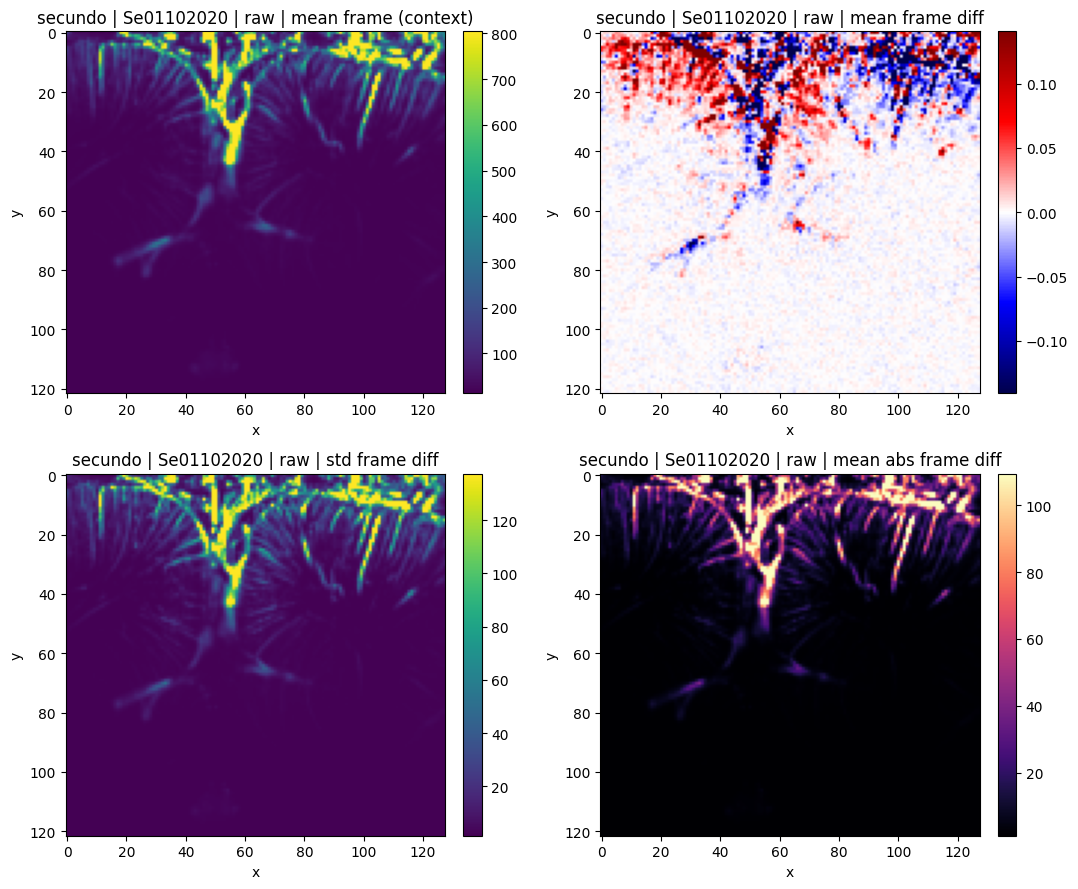

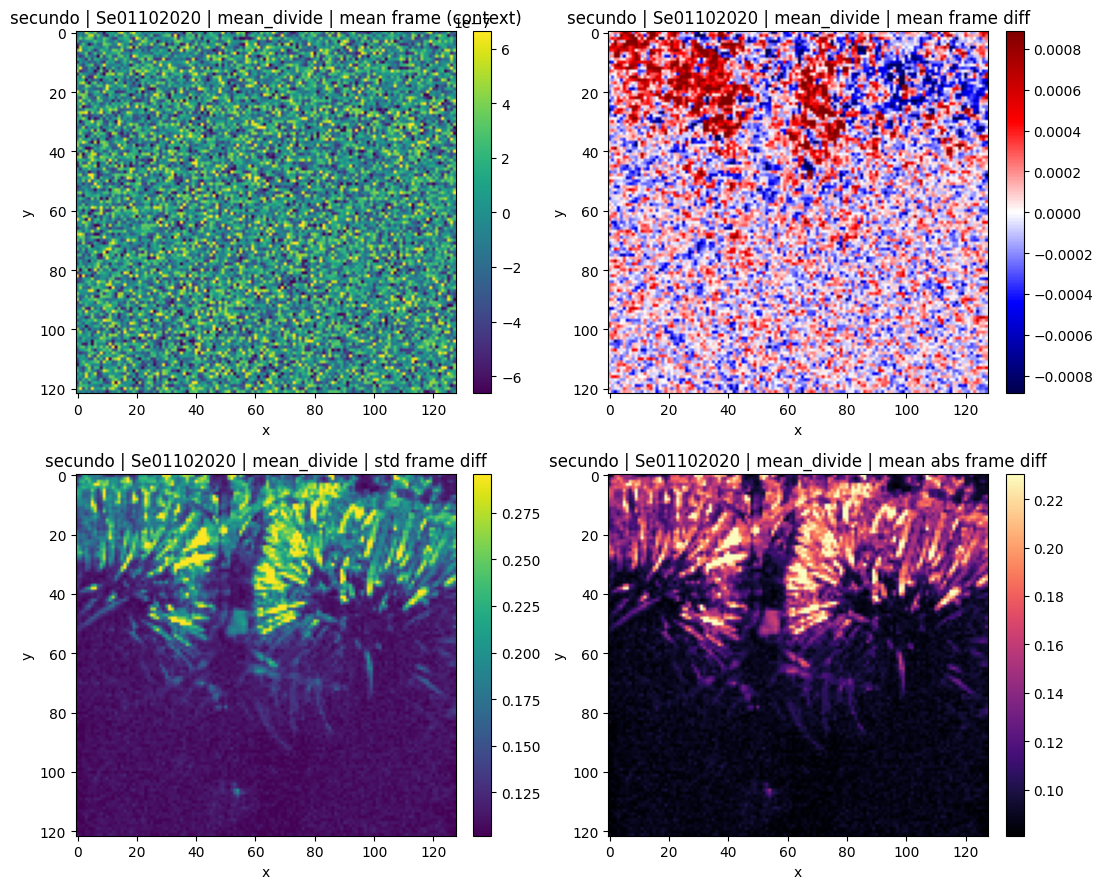

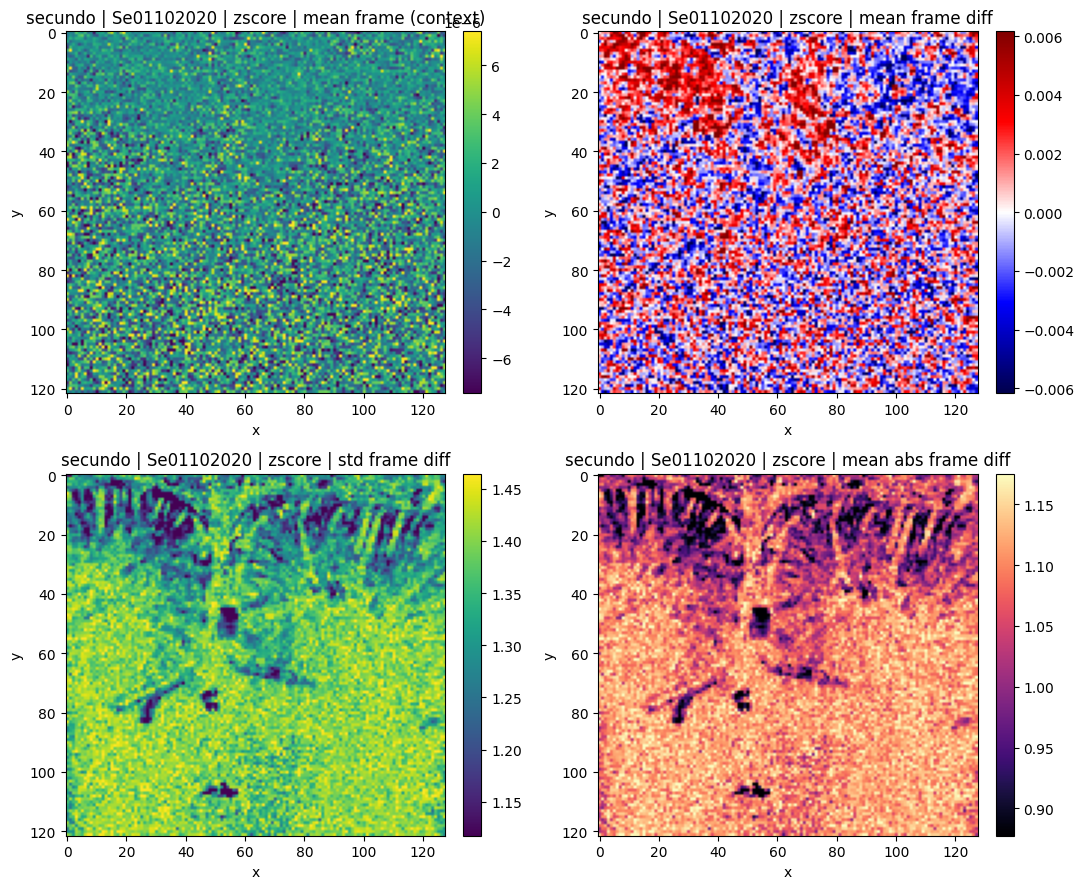

  - skip Se27072020 | raw: not enough frames (1)
  - skip Se27072020 | mean_divide: not enough frames (1)
  - skip Se27072020 | zscore: not enough frames (1)
  - skip Se31012020 | raw: not enough frames (1)
  - skip Se31012020 | mean_divide: not enough frames (1)
  - skip Se31012020 | zscore: not enough frames (1)
Saved per-acquisition frame-diff outputs to: c:\Users\ESPCI\Documents\GitHub\fUSPredict\derivatives\preprocessing\secundo\eda\frame_diff\per_session
Loaded 13 baseline sessions
\n[gus] frame-to-frame diff per acquisition | sessions=13
Saved per-acquisition frame-diff outputs to: c:\Users\ESPCI\Documents\GitHub\fUSPredict\derivatives\preprocessing\gus\eda\frame_diff\per_session


In [18]:
for subject in subjects:
    baseline_dir = deriv_root / subject / "baseline_only"
    baseline_sessions = hf.load_all_baseline(str(baseline_dir))
    print(
        f"\\n[{subject}] frame-to-frame diff per acquisition | sessions={len(baseline_sessions)}"
    )
    if len(baseline_sessions) == 0:
        continue

    out_dir = acf.analysis_subject_root(subject, FDIFF_ROOT_SUBDIR) / "per_session"
    out_dir.mkdir(parents=True, exist_ok=True)

    for s_idx, session in enumerate(baseline_sessions):
        session_id = session["session_id"]

        for mode in analysis_modes:
            try:
                arr, metadata, _ = acf.load_saved_session_bundle(
                    deriv_root, subject, session_id, mode
                )
            except Exception as e:
                print(f"  - skip {session_id} | {mode}: {e}")
                pd.DataFrame(
                    [
                        {
                            "subject": subject,
                            "session_id": session_id,
                            "mode": mode,
                            "status": "missing_or_invalid",
                            "reason": str(e),
                        }
                    ]
                ).to_csv(
                    out_dir / f"{subject}_{session_id}_{mode}_frame_diff_summary.csv",
                    index=False,
                )
                continue

            if arr.shape[0] < 2:
                msg = f"not enough frames ({arr.shape[0]})"
                print(f"  - skip {session_id} | {mode}: {msg}")
                pd.DataFrame(
                    [
                        {
                            "subject": subject,
                            "session_id": session_id,
                            "mode": mode,
                            "status": "insufficient_frames",
                            "reason": msg,
                        }
                    ]
                ).to_csv(
                    out_dir / f"{subject}_{session_id}_{mode}_frame_diff_summary.csv",
                    index=False,
                )
                continue

            if FRAME_DIFF_METHOD != "consecutive":
                raise ValueError(
                    f"Unsupported FRAME_DIFF_METHOD={FRAME_DIFF_METHOD!r}; expected 'consecutive'"
                )

            diff = arr[1:] - arr[:-1]
            context_mean = np.nanmean(arr, axis=0)
            diff_mean_map = np.nanmean(diff, axis=0)
            diff_std_map = np.nanstd(diff, axis=0)
            diff_abs_mean_map = np.nanmean(np.abs(diff), axis=0)

            context_vmin, context_vmax = acf.robust_limits(
                context_mean, pctl=fdiff_robust_pctl
            )
            dm_vmin, dm_vmax = acf.robust_limits(
                diff_mean_map, pctl=fdiff_robust_pctl, symmetric=True
            )
            ds_vmin, ds_vmax = acf.robust_limits(
                diff_std_map, pctl=fdiff_robust_pctl, nonnegative=True
            )
            da_vmin, da_vmax = acf.robust_limits(
                diff_abs_mean_map, pctl=fdiff_robust_pctl, nonnegative=True
            )

            fig, axes = plt.subplots(2, 2, figsize=FRAME_DIFF_FIGSIZE)
            panels = [
                (
                    context_mean,
                    "viridis",
                    (context_vmin, context_vmax),
                    "mean frame (context)",
                ),
                (diff_mean_map, "seismic", (dm_vmin, dm_vmax), "mean frame diff"),
                (diff_std_map, "viridis", (ds_vmin, ds_vmax), "std frame diff"),
                (diff_abs_mean_map, "magma", (da_vmin, da_vmax), "mean abs frame diff"),
            ]
            for ax, (img, cmap, (vmin, vmax), title) in zip(axes.ravel(), panels, strict=False):
                im = ax.imshow(img, cmap=cmap, vmin=vmin, vmax=vmax)
                ax.set_title(f"{subject} | {session_id} | {mode} | {title}")
                ax.set_xlabel("x")
                ax.set_ylabel("y")
                fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

            fig.tight_layout()
            out_fig = out_dir / f"{subject}_{session_id}_{mode}_frame_diff_maps.png"
            fig.savefig(out_fig, dpi=FRAME_DIFF_SAVE_DPI)

            if subject == sample_subject and s_idx == sample_session_idx:
                plt.show()
            else:
                plt.close(fig)

            n_finite = int(np.isfinite(diff).sum())
            fps = np.nan
            if "source_fps" in metadata:
                try:
                    fps = float(np.asarray(metadata["source_fps"]).item())
                except Exception:
                    fps = np.nan

            summary = {
                "subject": subject,
                "session_id": session_id,
                "mode": mode,
                "status": "ok",
                "n_frames": int(arr.shape[0]),
                "n_diff_frames": int(diff.shape[0]),
                "height": int(arr.shape[1]),
                "width": int(arr.shape[2]),
                "n_finite_diff_values": n_finite,
                "global_diff_mean": float(np.nanmean(diff)),
                "global_diff_std": float(np.nanstd(diff)),
                "global_diff_abs_mean": float(np.nanmean(np.abs(diff))),
                "source_fps": fps,
            }
            pd.DataFrame([summary]).to_csv(
                out_dir / f"{subject}_{session_id}_{mode}_frame_diff_summary.csv",
                index=False,
            )

    print(f"Saved per-acquisition frame-diff outputs to: {out_dir}")

across acquisitions

Loaded 34 baseline sessions
\n[secundo] frame-to-frame diff across acquisitions | sessions=34


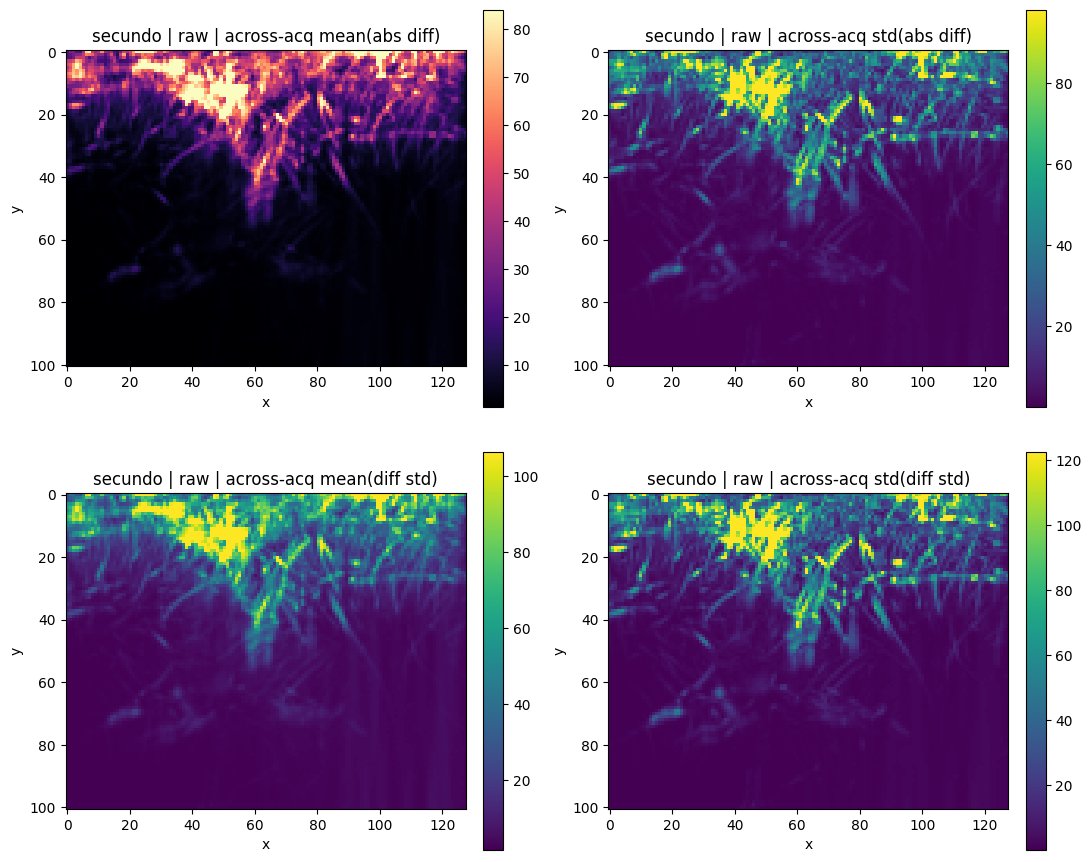

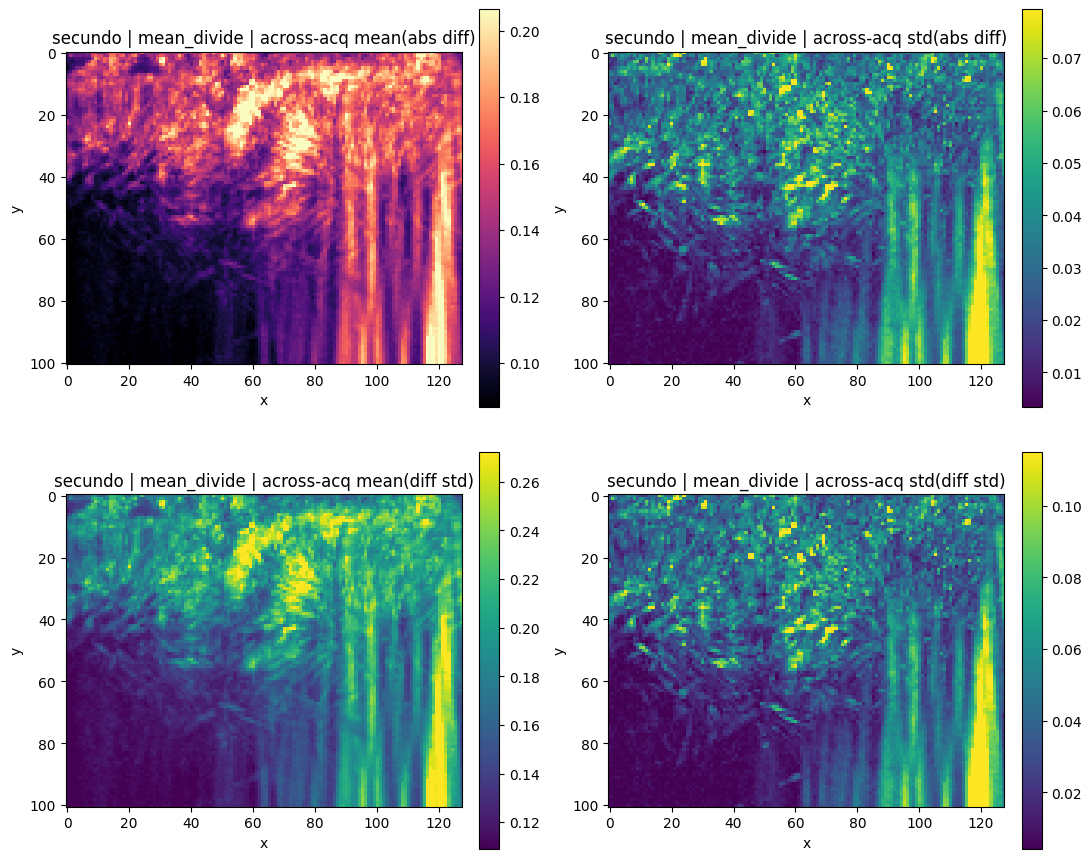

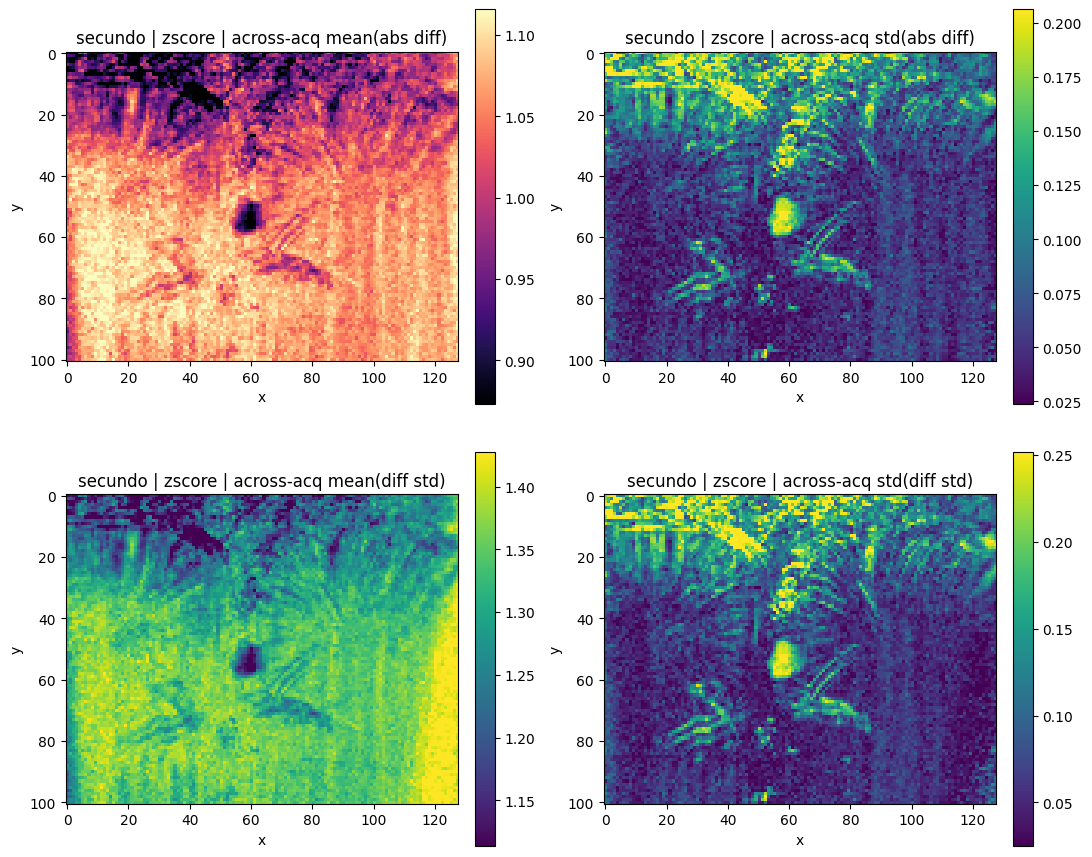

Saved across-acquisition frame-diff outputs to: c:\Users\ESPCI\Documents\GitHub\fUSPredict\derivatives\preprocessing\secundo\eda\frame_diff\across_sessions
Loaded 13 baseline sessions
\n[gus] frame-to-frame diff across acquisitions | sessions=13
Saved across-acquisition frame-diff outputs to: c:\Users\ESPCI\Documents\GitHub\fUSPredict\derivatives\preprocessing\gus\eda\frame_diff\across_sessions


In [19]:
for subject in subjects:
    baseline_dir = deriv_root / subject / "baseline_only"
    baseline_sessions = hf.load_all_baseline(str(baseline_dir))
    print(
        f"\\n[{subject}] frame-to-frame diff across acquisitions | sessions={len(baseline_sessions)}"
    )
    if len(baseline_sessions) == 0:
        continue

    out_dir = acf.analysis_subject_root(subject, FDIFF_ROOT_SUBDIR) / "across_sessions"
    out_dir.mkdir(parents=True, exist_ok=True)

    for mode in analysis_modes:
        session_maps_abs = []
        session_maps_std = []
        used_session_ids = []
        skipped_shape = 0
        skipped_other = 0
        ref_shape = None

        for session in baseline_sessions:
            session_id = session["session_id"]
            try:
                arr, _, _ = acf.load_saved_session_bundle(
                    deriv_root, subject, session_id, mode
                )
                if arr.shape[0] < 2:
                    skipped_other += 1
                    continue

                if FRAME_DIFF_METHOD != "consecutive":
                    raise ValueError(
                        f"Unsupported FRAME_DIFF_METHOD={FRAME_DIFF_METHOD!r}"
                    )
                diff = arr[1:] - arr[:-1]

                shape_hw = arr.shape[1:]
                if ref_shape is None:
                    ref_shape = shape_hw
                elif shape_hw != ref_shape:
                    skipped_shape += 1
                    continue

                session_maps_abs.append(np.nanmean(np.abs(diff), axis=0))
                session_maps_std.append(np.nanstd(diff, axis=0))
                used_session_ids.append(session_id)
            except Exception:
                skipped_other += 1

        total_sessions = len(baseline_sessions)
        used_sessions = len(used_session_ids)

        if used_sessions == 0:
            pd.DataFrame(
                [
                    {
                        "subject": subject,
                        "mode": mode,
                        "status": "no_valid_sessions",
                        "n_sessions_total": int(total_sessions),
                        "n_sessions_used": 0,
                        "n_sessions_skipped_shape": int(skipped_shape),
                        "n_sessions_skipped_other": int(skipped_other),
                        "shape_ref": "",
                    }
                ]
            ).to_csv(
                out_dir / f"{subject}_{mode}_frame_diff_across_summary.csv", index=False
            )
            print(f"  - skip mode={mode}: no valid sessions")
            continue

        ABS = np.stack(session_maps_abs, axis=0)
        STD = np.stack(session_maps_std, axis=0)

        abs_across_mean = np.nanmean(ABS, axis=0)
        abs_across_std = np.nanstd(ABS, axis=0)
        std_across_mean = np.nanmean(STD, axis=0)
        std_across_std = np.nanstd(STD, axis=0)

        fig, axes = plt.subplots(2, 2, figsize=FRAME_DIFF_FIGSIZE)
        panels = [
            (
                abs_across_mean,
                "magma",
                acf.robust_limits(
                    abs_across_mean, pctl=fdiff_robust_pctl, nonnegative=True
                ),
                f"{subject} | {mode} | across-acq mean(abs diff)",
            ),
            (
                abs_across_std,
                "viridis",
                acf.robust_limits(
                    abs_across_std, pctl=fdiff_robust_pctl, nonnegative=True
                ),
                f"{subject} | {mode} | across-acq std(abs diff)",
            ),
            (
                std_across_mean,
                "viridis",
                acf.robust_limits(
                    std_across_mean, pctl=fdiff_robust_pctl, nonnegative=True
                ),
                f"{subject} | {mode} | across-acq mean(diff std)",
            ),
            (
                std_across_std,
                "viridis",
                acf.robust_limits(
                    std_across_std, pctl=fdiff_robust_pctl, nonnegative=True
                ),
                f"{subject} | {mode} | across-acq std(diff std)",
            ),
        ]

        for ax, (img, cmap, (vmin, vmax), title) in zip(axes.ravel(), panels):
            im = ax.imshow(img, cmap=cmap, vmin=vmin, vmax=vmax)
            ax.set_title(title)
            ax.set_xlabel("x")
            ax.set_ylabel("y")
            fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

        fig.tight_layout()
        out_fig = out_dir / f"{subject}_{mode}_frame_diff_across_maps.png"
        fig.savefig(out_fig, dpi=FRAME_DIFF_SAVE_DPI)

        if subject == sample_subject:
            plt.show()
        else:
            plt.close(fig)

        summary_row = {
            "subject": subject,
            "mode": mode,
            "status": "ok",
            "n_sessions_total": int(total_sessions),
            "n_sessions_used": int(used_sessions),
            "n_sessions_skipped_shape": int(skipped_shape),
            "n_sessions_skipped_other": int(skipped_other),
            "shape_ref": str(tuple(int(x) for x in ref_shape)),
            "used_session_ids": "|".join(str(s) for s in used_session_ids),
            "global_abs_diff_mean": float(np.nanmean(abs_across_mean)),
            "global_abs_diff_std": float(np.nanstd(abs_across_mean)),
            "global_diff_std_mean": float(np.nanmean(std_across_mean)),
            "global_diff_std_std": float(np.nanstd(std_across_mean)),
        }
        pd.DataFrame([summary_row]).to_csv(
            out_dir / f"{subject}_{mode}_frame_diff_across_summary.csv", index=False
        )

    print(f"Saved across-acquisition frame-diff outputs to: {out_dir}")